# Comparing a USGSCSM and ISIS Camera Model

## Prerequisites

This comparison notebook requires the installation of ISIS. Follow the instructions in the [ISIS Installation With Conda guide](https://astrogeology.usgs.gov/docs/how-to-guides/environment-setup-and-maintenance/installing-isis-via-anaconda/).

In [1]:
import os 

# kalasiris requires ISISROOT and ISISDATA environment variables to be set.
os.environ['ISISROOT'] = os.path.join(os.environ['HOME'],'opt','anaconda3','envs','isis-prod')
os.environ['ISISDATA'] = "/Volumes/isis_data1/isis_data"

import kalasiris.pysis as isis

from knoten import vis

import json
import ale

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Download PDS Image

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

!wget -N -P data/ {url} --no-check-certificate
fileName = 'data/' + os.path.split(url)[1]

--2024-05-22 08:02:58--  https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 52.34.231.99, 52.38.23.64
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|52.34.231.99|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: https://planetarydata.jpl.nasa.gov/img/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG [following]
--2024-05-22 08:02:59--  https://planetarydata.jpl.nasa.gov/img/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving planetarydata.jpl.nasa.gov (planetarydata.jpl.nasa.gov)... 207.151.104.173
Connecting to planetarydata.jpl.nasa.gov (planetarydata.jpl.nasa.gov)|207.151.104.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243340224 (232M)
Savi

## Ingest the image into ISIS and attach SPICE via spiceinit

In [3]:
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except isis.ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except isis.ProcessError as e:
    print(e.stderr)

## Create an ISD from the PDS3 .IMG using ISIS cube kernels and store it next to the cube

In [4]:
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels})

csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)
    
usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

/Users/astamile/opt/anaconda3/envs/knoten/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning:

Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.



In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

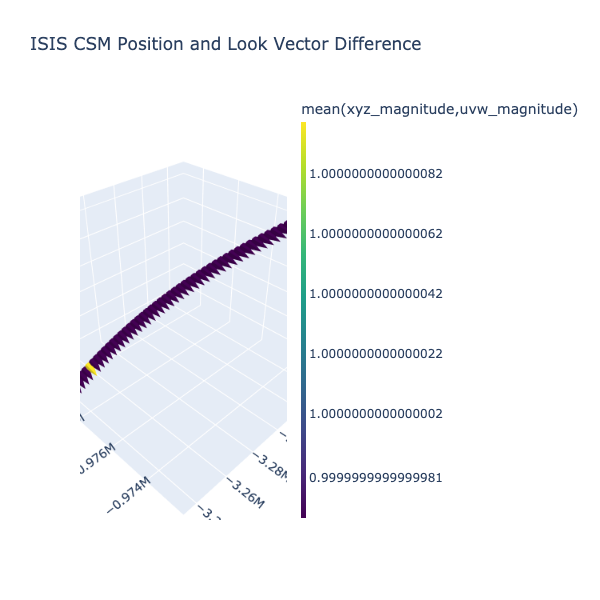

In [6]:
Image(csmisis_diff_lv_plot.to_image())

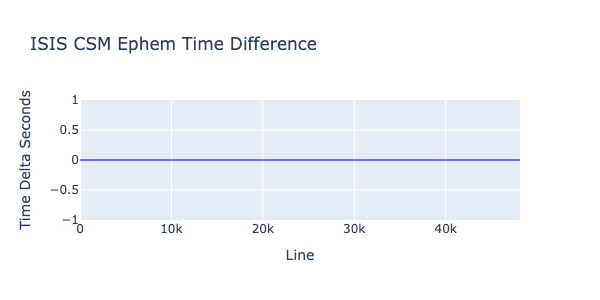

In [7]:
Image(csmisis_diff_ephem_plot.to_image())

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,0.000077,0.000199,-0.000011,1.154782e-08,-8.894654e-08,3.882977e-08
std,0.000400,0.000937,0.000149,9.456094e-08,3.383175e-07,2.598414e-07
min,-0.000793,-0.001727,-0.000340,-2.586859e-07,-1.258628e-06,-4.987500e-07
25%,-0.000263,-0.000527,-0.000126,-4.523316e-08,-2.640964e-07,-1.078950e-07
50%,0.000080,0.000161,0.000001,2.748548e-09,-2.273913e-09,1.208859e-08
75%,0.000440,0.000950,0.000081,4.468993e-08,1.343876e-07,1.812972e-07
max,0.000811,0.002111,0.000316,3.097324e-07,5.573508e-07,7.271875e-07


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600, edge_pad=0.01)

/Users/astamile/opt/anaconda3/envs/knoten/lib/python3.12/site-packages/knoten-0.4.0-py3.12.egg/knoten/vis.py:61: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



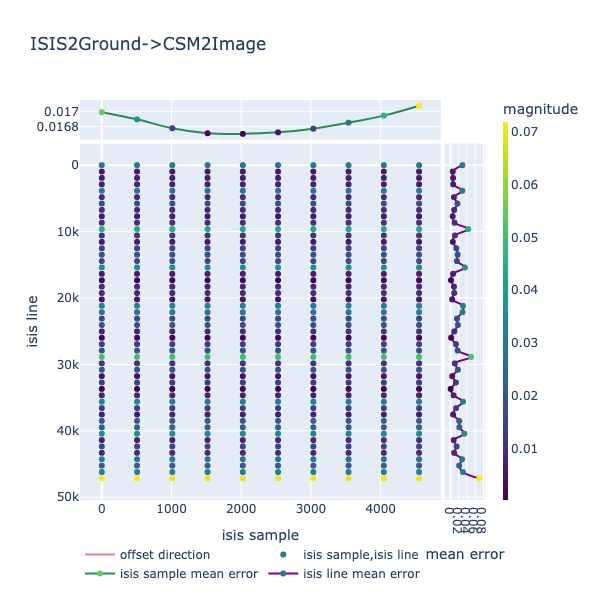

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.001298,0.004654
std,0.010907,0.018035
min,-0.022728,-0.030098
25%,-0.005129,-0.007006
50%,0.000238,-0.000235
75%,0.007018,0.014009
max,0.028891,0.068042


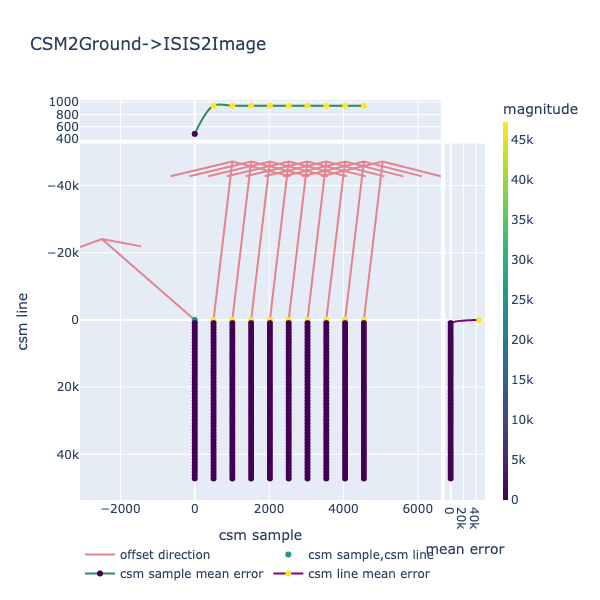

In [12]:
Image(csm2isis_plot.to_image())

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-897.106921,4.096432
std,6362.131063,130.814763
min,-47165.463281,-2499.490000
25%,-0.007136,-0.013755
50%,-0.000778,0.000471
75%,0.004779,0.008466
max,0.023008,505.534352


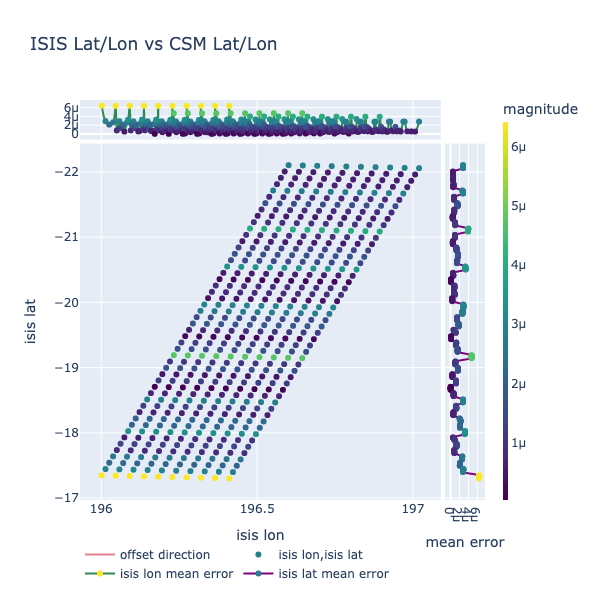

In [14]:
Image(isiscsm_plotlatlon.to_image())

In [15]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,5.000000e+02,5.000000e+02
mean,4.054152e-07,1.786892e-07
std,1.571631e-06,1.196634e-06
min,-2.647452e-06,-2.292322e-06
25%,-5.690899e-07,-5.002277e-07
50%,3.618256e-08,4.712217e-08
75%,1.188245e-06,8.394656e-07
max,5.674273e-06,3.343632e-06


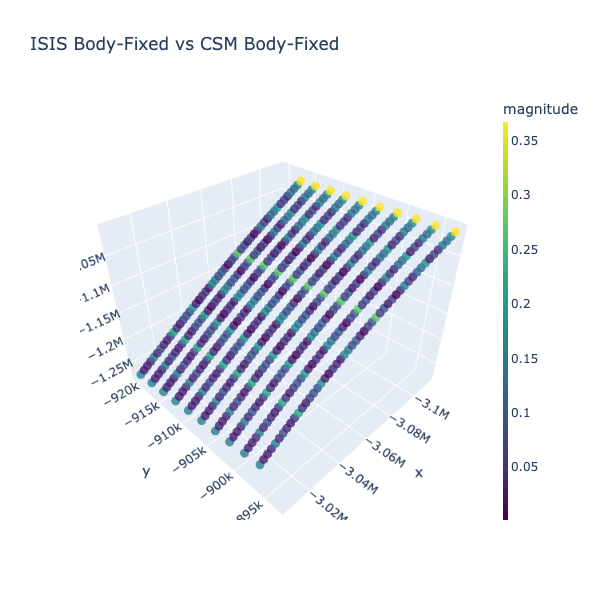

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.117837,0.022819,-0.009910
std,1.708421,0.087658,0.066955
min,-3.141190,-0.143720,-0.186873
25%,-0.862259,-0.033847,-0.046929
50%,-0.173627,0.000487,-0.002619
75%,1.865580,0.068426,0.028154
max,3.140255,0.323277,0.128875
